In [1]:
%matplotlib inline

In [2]:
from Bio import SeqIO
from matplotlib import pyplot as plt
from scipy import stats

In [3]:
import pybedtools

In [4]:
from pybedtools.contrib.bigwig import bam_to_bigwig
from pybedtools import genome_registry
# pybedtools.helpers.chromsizes()

# Converting bam files to .wig
Just testing all this code to make sure it works

In [ ]:
# genome_registry.neisseria
#genome_registry.dm3['NC_002946'] = (0,2153922)

In [ ]:
# bam_to_bigwig(bam='/Users/adamhockenberry/workspace/kallisto/neisseria_testing/out_sorted.bam',\
#               genome='neisseria', output='/Users/adamhockenberry/workspace/kallisto/neisseria_testing/out.bigwig')

In [ ]:
# x = pybedtools.BedTool('/Users/adamhockenberry/workspace/kallisto/test/out.bam')
# x.genome_coverage(bg=True, genome='neisseria', split=True)\
#     .saveas('/Users/adamhockenberry/workspace/kallisto/test/outnew.bed', trackline='track name="test track" visibility="full" type=bedGraph')

In [ ]:
# pybedtools.chromsizes_to_file(pybedtools.chromsizes('neisseria'), '/Users/adamhockenberry/workspace/kallisto/test/neisseria_test.genome')

# Need a .fasta file of all transcripts! 
### Can (perhaps should?) consider including separate "transcripts" for intragenic seqs?

In [6]:
genome = list(SeqIO.parse('../Data/Genomes/fa1090.gb', 'genbank'))

In [7]:
assert len(genome) == 1
genome = genome[0]
print(len(genome.seq))

2153922


In [ ]:
# output_handle = open("fa1090.annotatedCDS.fasta", "w")
for feature in genome.features:
    if feature.type == 'CDS':
        if 'locus_tag' in feature.qualifiers:
            gene_name = feature.qualifiers['locus_tag'][0]
        else:
            continue
    else:
        continue
    output_handle.write(">" + gene_name + "\n" + str(feature.extract(genome.seq)) + "\n")
output_handle.close()


# Converting SAM to WIGGLE

In [ ]:
sam_file = '/Users/adamhockenberry/workspace/kallisto/neisseria_04_22_16/SQ1.sam'
wiggle_out_f = '/Users/adamhockenberry/workspace/kallisto/neisseria_testing/out_f.wig'
wiggle_out_r = '/Users/adamhockenberry/workspace/kallisto/neisseria_testing/out_r.wig'
genome_list = list(SeqIO.parse('../Data/Genomes/fa1090.gb', 'genbank'))

length_restriction = (20, 100)

In [ ]:
fwd_dicty = {} #These dictionaries will contain position:read_count pairs for all mapped locations
rev_dicty = {}
mapped_len_dict = {}
mapped_len_dict['Plus'] = []
mapped_len_dict['Minus'] = []
mapped_len_dict['Unmapped'] = []
with open(sam_file, 'r') as infile:
    for line in infile:
        if line[0] == '@':
            continue
        split_line = line.split('\t')
        seq = split_line[9] #In the sam file position 10 (index 9) should contain the mapped sequence
        seq_length = len(seq)
        if split_line[1] == '4':
            mapped_len_dict['Unmapped'].append(seq_length)
            continue
        if seq_length < length_restriction[0] or seq_length > length_restriction[1]:
            mapped_len_dict['Unmapped'].append(seq_length)
            continue
        start_loc = int(split_line[3])-1 #I noticed the subtraction of one is necessary for proper mapping
        end_loc = start_loc+seq_length
        if split_line[1] == '0':
            mapped_len_dict['Plus'].append(seq_length)
        elif split_line[1] == '16':
            mapped_len_dict['Minus'].append(seq_length)

        if split_line[1] == '0':
            for i in range(start_loc, end_loc + 1):
                try:
                    fwd_dicty[i] += 1
                except KeyError:
                    fwd_dicty[i] = 1
        elif split_line[1] == '16':
            for i in range(start_loc, end_loc + 1):
                try:
                    rev_dicty[i] += 1
                except KeyError:
                    rev_dicty[i] = 1

# fwd_dicty_rpkm, rev_dicty_rpkm = normalize_dicts(fwd_dicty, rev_dicty, genome_list)

    ############################################################################################
    #Writing the basic output files
#     output_file_base = sam_file_name.split('/')[-1].split('.')[0]
#     with open('../Data/{}/{}_{}_{}_{}_f.wig'.format(organism, output_file_base, length_restriction[0], length_restriction[1], assignment), 'w') as outfile:
#         for pos in sorted(list(fwd_dicty.keys())):
#             outfile.write('{}\t{}\n'.format(pos, fwd_dicty[pos]))

#     with open('../Data/{}/{}_{}_{}_{}_r.wig'.format(organism, output_file_base, length_restriction[0], length_restriction[1], assignment), 'w') as outfile:
#         for pos in sorted(list(rev_dicty.keys())):
#             outfile.write('{}\t{}\n'.format(pos, rev_dicty[pos]))

#     with open('../Data/{}/{}_{}_{}_{}_normed_f.wig'.format(organism, output_file_base, length_restriction[0], length_restriction[1], assignment), 'w') as outfile:
#         for pos in sorted(list(fwd_dicty_rpkm.keys())):
#             outfile.write('{}\t{}\n'.format(pos, fwd_dicty_rpkm[pos]))

#     with open('../Data/{}/{}_{}_{}_{}_normed_r.wig'.format(organism, output_file_base, length_restriction[0], length_restriction[1], assignment), 'w') as outfile:
#         for pos in sorted(list(rev_dicty_rpkm.keys())):
#             outfile.write('{}\t{}\n'.format(pos, rev_dicty_rpkm[pos]))



In [ ]:
total_in_CDS = []
for genome in genome_list:
    for feature in genome.features:
        if feature.type == 'CDS':
            pos = (feature.location.start, feature.location.end)
            if feature.strand == 1:
                for i in range(pos[0], pos[1]):
                    try:
                        total_in_CDS.append(fwd_dicty[i])
                    except KeyError:
                        pass
            elif feature.strand == -1: 
                for i in range(pos[0], pos[1]):
                    try:
                        total_in_CDS.append(rev_dicty[i])
                    except KeyError:
                        pass

total_mapped = sum(total_in_CDS)
fwd_dicty_normed = {}
rev_dicty_normed = {}
for pos in fwd_dicty:
    fwd_dicty_normed[pos] = (fwd_dicty[pos])/(total_mapped/1000000000.)
for pos in rev_dicty:
    rev_dicty_normed[pos] = (rev_dicty[pos])/(total_mapped/1000000000.)

In [ ]:
with open('/Users/adamhockenberry/workspace/kallisto/neisseria_testing/out_f.wig', 'w') as outfile:
    outfile.write('variableStep chrom=NC_002946 \n')
    for pos in sorted(list(fwd_dicty.keys())):
        outfile.write('{}\t{}\n'.format(pos, fwd_dicty[pos]))
with open('/Users/adamhockenberry/workspace/kallisto/neisseria_testing/out_r.wig', 'w') as outfile:
    outfile.write('variableStep chrom=NC_002946 \n')
    for pos in sorted(list(rev_dicty.keys())):
        outfile.write('{}\t{}\n'.format(pos, rev_dicty[pos]))
with open('/Users/adamhockenberry/workspace/kallisto/neisseria_testing/out_normed_f.wig', 'w') as outfile:
    outfile.write('variableStep chrom=NC_002946 \n')
    for pos in sorted(list(fwd_dicty_normed.keys())):
        outfile.write('{}\t{}\n'.format(pos, fwd_dicty_normed[pos]))
with open('/Users/adamhockenberry/workspace/kallisto/neisseria_testing/out_normed_r.wig', 'w') as outfile:
    outfile.write('variableStep chrom=NC_002946 \n')
    for pos in sorted(list(rev_dicty_normed.keys())):
        outfile.write('{}\t{}\n'.format(pos, rev_dicty_normed[pos]))


In [ ]:
fwd_dicty[1000]

# Kallisto datatable

In [6]:
import pandas as pd
import numpy as np

In [7]:
df1 = pd.read_csv('/Users/adamhockenberry/workspace/kallisto/neisseria_04_22_16/Neisseria_kallisto_test_table.csv', index_col='target_id')
df1 = df1.drop('Unnamed: 0', 1)
df2 = pd.read_csv('/Users/adamhockenberry/workspace/kallisto/neisseria_04_22_16/neisseria_kallisto_table.csv')
df2 = df2.drop('Unnamed: 0', 1)

In [8]:
for i in ['SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6']:
    df1[i] = ''

In [9]:
df2.columns

Index(['target_id', 'sample', 'est_counts', 'tpm', 'eff_len', 'len'], dtype='object')

In [10]:
for index in df2.index:
    df1.ix[df2.loc[index]['target_id'], df2.loc[index]['sample']] = df2.loc[index]['tpm']

In [11]:
df1['avg(SQ1,SQ3,SQ5)'] = np.nan
df1['avg(SQ2,SQ4,SQ6)'] = np.nan
df1['log2_FC'] = np.nan
for index in df1.index:
    try:
        df1.ix[index, 'avg(SQ2,SQ4,SQ6)'] = np.mean([df1.loc[index]['SQ2'], df1.loc[index]['SQ4'], df1.loc[index]['SQ6']])
    except TypeError:
        pass
    try:
        df1.ix[index, 'avg(SQ1,SQ3,SQ5)'] = np.mean([df1.loc[index]['SQ1'], df1.loc[index]['SQ3'], df1.loc[index]['SQ5']])
    except TypeError:
        pass
    try:
        df1.ix[index, 'log2_FC'] = np.log2(np.exp(df1.ix[index, 'b']))
    except TypeError:
        pass

In [12]:
df1.columns

Index(['pval', 'qval', 'b', 'se_b', 'mean_obs', 'var_obs', 'tech_var',
       'sigma_sq', 'smooth_sigma_sq', 'final_sigma_sq', 'SQ1', 'SQ2', 'SQ3',
       'SQ4', 'SQ5', 'SQ6', 'avg(SQ1,SQ3,SQ5)', 'avg(SQ2,SQ4,SQ6)', 'log2_FC'],
      dtype='object')

In [13]:
df_compact = df1[['SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6', 'avg(SQ1,SQ3,SQ5)', 'avg(SQ2,SQ4,SQ6)', 'log2_FC', 'qval', 'pval']]

In [14]:
df_compact_sorted = df_compact.sort_index(axis=0)

In [15]:
df_best = df_compact[(abs(df_compact.log2_FC) > 1) & (df_compact.qval < 0.05)]
len(df_best.index)

52

In [115]:
# writer = pd.ExcelWriter('/Users/adamhockenberry/workspace/kallisto/neisseria_04_22_16/compact_table_04_27_17.xlsx', engine='xlsxwriter')
# df_compact.to_excel(writer, sheet_name='Sheet1')
# writer.save()
# writer = pd.ExcelWriter('/Users/adamhockenberry/workspace/kallisto/neisseria_04_22_16/compact_table_sorted_04_27_17.xlsx', engine='xlsxwriter')
# df_compact_sorted.to_excel(writer, sheet_name='Sheet1')
# writer.save()
# writer = pd.ExcelWriter('/Users/adamhockenberry/workspace/kallisto/neisseria_04_22_16/compact_table_best_04_27_17.xlsx', engine='xlsxwriter')
# df_best.to_excel(writer, sheet_name='Sheet1')
# writer.save()

In [15]:
df_best

,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,"avg(SQ1,SQ3,SQ5)","avg(SQ2,SQ4,SQ6)",log2_FC,qval,pval
target_id,,,,,,,,,,,
NGO0025,4.5175,84.3182,4.93968,68.1287,4.19818,100.104,4.551788,84.183685,4.187594,1.599414e-107,8.645483e-111
NGO0636,315.638,1436.98,278.865,1721.89,313.673,1838.26,302.725372,1665.709798,2.454447,4.066169e-87,4.395858e-90
NGO1767,2117.62,10022.4,2471.34,12552.5,2139.67,12584.1,2242.877520,11719.670845,2.380977,9.615642e-71,1.559293e-73
NGO1769,289.857,56.6786,250.419,52.9252,248.29,62.4957,262.854993,57.366473,-2.195466,8.837634e-57,1.910840e-59
NGO1029,117.687,602.8,132.772,601.607,122.044,821.001,124.167826,675.136232,2.428543,1.408308e-50,3.806238e-53
NGO1046,465.677,2425.15,419.813,1763.07,434.121,1915.56,439.870331,2034.592914,2.197323,4.197741e-50,1.361429e-52
NGO1370,40.3005,6.83327,40.2788,5.95488,37.3363,4.97186,39.305183,5.920005,-2.739243,7.885386e-50,2.983660e-52
NGO0637,269.912,1486.75,232.446,1592.31,284.511,1171.07,262.289842,1416.712623,2.425942,1.342766e-49,5.806556e-52
NGO1215,1871.48,442.303,2248.1,456.479,1646.03,509.606,1921.870056,469.462813,-2.024289,2.845609e-42,1.384350e-44


In [16]:
df_compact = df_compact.loc[df_compact['log2_FC'].isnull() == False]

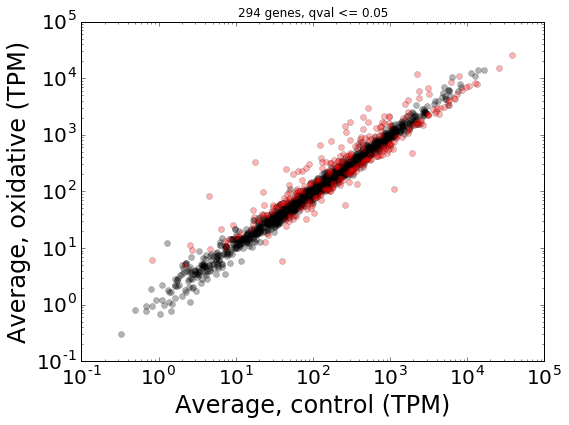

In [18]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
x_data = df_compact.loc[df_compact['qval'] > 0.05]['avg(SQ1,SQ3,SQ5)']
y_data = df_compact.loc[df_compact['qval'] > 0.05]['avg(SQ2,SQ4,SQ6)']
ax1.loglog(x_data, y_data, 'ko', alpha=0.3)
x_data = df_compact.loc[df_compact['qval'] <= 0.05]['avg(SQ1,SQ3,SQ5)']
y_data = df_compact.loc[df_compact['qval'] <= 0.05]['avg(SQ2,SQ4,SQ6)']
ax1.loglog(x_data, y_data, 'ro', alpha=0.3)

ax1.tick_params(labelsize=20)
ax1.set_xlabel('Average, control (TPM)', fontsize=24)
ax1.set_ylabel('Average, oxidative (TPM)', fontsize=24)
ax1.set_title('{} genes, qval <= 0.05'.format(len(y_data)))
plt.tight_layout()
plt.savefig('../Results/2016_11_02/scatter_all_sig.pdf')

52
LinregressResult(slope=0.8537538205166022, intercept=1.5756701689353658, rvalue=0.86633174768368904, pvalue=1.0846571494116583e-16, stderr=0.069610056277603596)


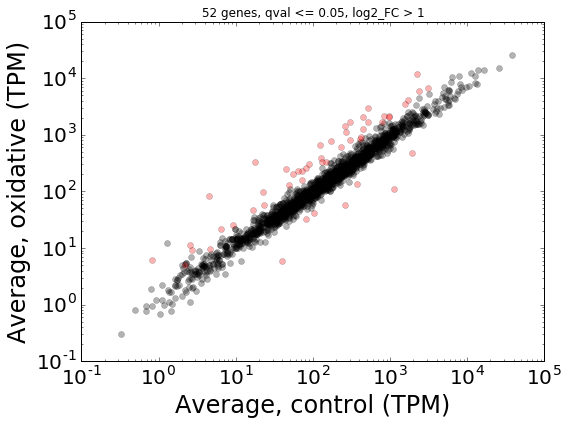

In [19]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
x_data = df_compact.loc[df_compact['qval'] > 0.05]['avg(SQ1,SQ3,SQ5)']
y_data = df_compact.loc[df_compact['qval'] > 0.05]['avg(SQ2,SQ4,SQ6)']
ax1.loglog(x_data, y_data, 'ko', alpha=0.3)
x_data = df_compact.loc[(df_compact['qval'] <= 0.05) & (np.abs(df_compact['log2_FC']) < 1.)]['avg(SQ1,SQ3,SQ5)']
y_data = df_compact.loc[(df_compact['qval'] <= 0.05) & (np.abs(df_compact['log2_FC']) < 1.)]['avg(SQ2,SQ4,SQ6)']
ax1.loglog(x_data, y_data, 'ko', alpha=0.3)
x_data = df_compact.loc[(df_compact['qval'] <= 0.05) & (np.abs(df_compact['log2_FC']) >= 1.)]['avg(SQ1,SQ3,SQ5)']
y_data = df_compact.loc[(df_compact['qval'] <= 0.05) & (np.abs(df_compact['log2_FC']) >= 1.)]['avg(SQ2,SQ4,SQ6)']
ax1.loglog(x_data, y_data, 'ro', alpha=0.3)

ax1.tick_params(labelsize=20)
ax1.set_xlabel('Average, control (TPM)', fontsize=24)
ax1.set_ylabel('Average, oxidative (TPM)', fontsize=24)
ax1.set_title('{} genes, qval <= 0.05, log2_FC > 1'.format(len(y_data)))
plt.tight_layout()
plt.savefig('../Results/2016_11_02/scatter_stricter.pdf')
print(len(x_data))
print(stats.linregress(np.log(x_data), np.log(y_data)))

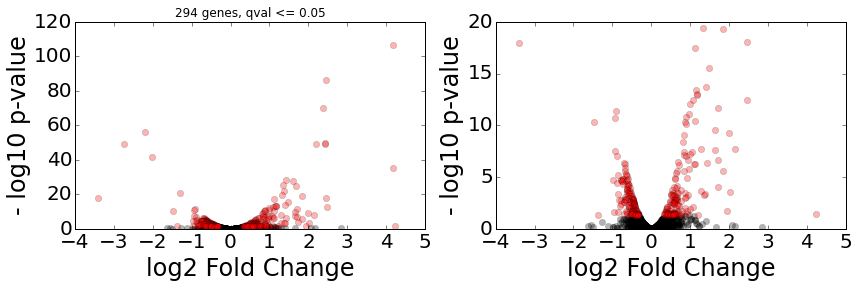

In [101]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
x_data = df_compact.loc[df_compact['qval'] > 0.05]['log2_FC']
y_data = df_compact.loc[df_compact['qval'] > 0.05]['qval']
ax1.plot(x_data, np.abs(np.log10(y_data)), 'ko', alpha=0.3)
x_data = df_compact.loc[df_compact['qval'] <= 0.05]['log2_FC']
y_data = df_compact.loc[df_compact['qval'] <= 0.05]['qval']
ax1.plot(x_data, np.abs(np.log10(y_data)), 'ro', alpha=0.3)

# ax1.set_ylim(0,20)
ax1.tick_params(labelsize=20)
ax1.set_xlabel('log2 Fold Change', fontsize=24)
ax1.set_ylabel('- log10 p-value', fontsize=24)

ax2 = fig.add_subplot(122)
x_data = df_compact.loc[df_compact['qval'] > 0.05]['log2_FC']
y_data = df_compact.loc[df_compact['qval'] > 0.05]['qval']
ax2.plot(x_data, np.abs(np.log10(y_data)), 'ko', alpha=0.3)
x_data = df_compact.loc[df_compact['qval'] <= 0.05]['log2_FC']
y_data = df_compact.loc[df_compact['qval'] <= 0.05]['qval']
ax2.plot(x_data, np.abs(np.log10(y_data)), 'ro', alpha=0.3)

ax2.set_ylim(0,20)
ax2.tick_params(labelsize=20)
ax2.set_xlabel('log2 Fold Change', fontsize=24)
ax2.set_ylabel('- log10 p-value', fontsize=24)
plt.tight_layout()
ax1.set_title('{} genes, qval <= 0.05'.format(len(y_data)))

plt.savefig('../Results/2016_07_26/volcano.pdf')

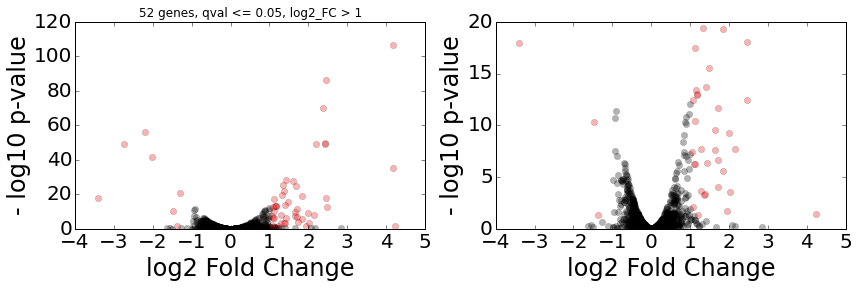

In [100]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
x_data = df_compact.loc[(df_compact['qval'] > 0.05)]['log2_FC']
y_data = df_compact.loc[(df_compact['qval'] > 0.05)]['qval']
ax1.plot(x_data, np.abs(np.log10(y_data)), 'ko', alpha=0.3)
x_data = df_compact.loc[(df_compact['qval'] <= 0.05) & (np.abs(df_compact['log2_FC']) < 1.)]['log2_FC']
y_data = df_compact.loc[(df_compact['qval'] <= 0.05) & (np.abs(df_compact['log2_FC']) < 1.)]['qval']
ax1.plot(x_data, np.abs(np.log10(y_data)), 'ko', alpha=0.3)
x_data = df_compact.loc[(df_compact['qval'] <= 0.05) & (np.abs(df_compact['log2_FC']) >= 1.)]['log2_FC']
y_data = df_compact.loc[(df_compact['qval'] <= 0.05) & (np.abs(df_compact['log2_FC']) >= 1.)]['qval']
ax1.plot(x_data, np.abs(np.log10(y_data)), 'ro', alpha=0.3)

ax1.tick_params(labelsize=20)
ax1.set_xlabel('log2 Fold Change', fontsize=24)
ax1.set_ylabel('- log10 p-value', fontsize=24)

ax2 = fig.add_subplot(122)
x_data = df_compact.loc[(df_compact['qval'] > 0.05)]['log2_FC']
y_data = df_compact.loc[(df_compact['qval'] > 0.05)]['qval']
ax2.plot(x_data, np.abs(np.log10(y_data)), 'ko', alpha=0.3)
x_data = df_compact.loc[(df_compact['qval'] <= 0.05) & (np.abs(df_compact['log2_FC']) < 1.)]['log2_FC']
y_data = df_compact.loc[(df_compact['qval'] <= 0.05) & (np.abs(df_compact['log2_FC']) < 1.)]['qval']
ax2.plot(x_data, np.abs(np.log10(y_data)), 'ko', alpha=0.3)
x_data = df_compact.loc[(df_compact['qval'] <= 0.05) & (np.abs(df_compact['log2_FC']) >= 1.)]['log2_FC']
y_data = df_compact.loc[(df_compact['qval'] <= 0.05) & (np.abs(df_compact['log2_FC']) >= 1.)]['qval']
ax2.plot(x_data, np.abs(np.log10(y_data)), 'ro', alpha=0.3)

ax2.set_ylim(0,20)
ax2.tick_params(labelsize=20)
ax2.set_xlabel('log2 Fold Change', fontsize=24)
ax2.set_ylabel('- log10 p-value', fontsize=24)
plt.tight_layout()
ax1.set_title('{} genes, qval <= 0.05, log2_FC > 1'.format(len(y_data)))
plt.savefig('../Results/2016_07_26/volcano_stricter.pdf')

In [76]:
print(len(df_compact['log2_FC']))
print(len(df_compact.loc[df_compact['log2_FC'].isnull() == False]))

1853
1853


In [87]:
print(len(df_compact.loc[(df_compact['qval'] <= 0.05) & (np.abs(df_compact['log2_FC']) >= 1.)]['qval']))

52


# Getting UTRs of best genes

In [3]:
import random

In [20]:
genome_list = list(SeqIO.parse('../Data/Genomes/fa1090.gb', 'genbank'))

In [21]:
df_compact.columns

Index(['SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6', 'avg(SQ1,SQ3,SQ5)',
       'avg(SQ2,SQ4,SQ6)', 'log2_FC', 'qval', 'pval'],
      dtype='object')

In [23]:
df_best = df_compact[(df_compact.log2_FC < 0) & (df_compact.qval < 0.05)]
len(df_best.index)

143

In [24]:
with open('../Results/2016_11_02/diff_exp_utrs_negative_100_0.fasta', 'w') as outfile:
    for genome in genome_list:
        for feature in genome.features:
            if feature.type == 'gene':
                if feature.qualifiers['locus_tag'][0] in df_best.index:
                    print(feature.qualifiers['locus_tag'][0], feature.strand)
                    beg = feature.location.start
                    end = feature.location.end
                    if feature.strand == 1:
                        seq = str(genome.seq[beg-100:beg])
                    elif feature.strand == -1:
                        seq = str(genome.seq[end:end+100].reverse_complement())
                    else:
                        print('what the fuckkkkk')
                    if len(seq)==100:
                        outfile.write('>{}|{}\n'.format(feature.qualifiers['locus_tag'][0], feature.strand))
                        outfile.write('{}\n'.format(seq))
                    else:
                        print('#############################')

NGO0033 -1
NGO0037 -1
NGO0042 -1
NGO0043 -1
NGO0044 -1
NGO0045 -1
NGO0098 -1
NGO0104 1
NGO0135 -1
NGO0149 -1
NGO0171 -1
NGO0191 1
NGO0209 -1
NGO0233 -1
NGO0234 -1
NGO0235 -1
NGO0292 -1
NGO0295 1
NGO0297 1
NGO0299 1
NGO0339 1
NGO0377 -1
NGO0442 1
NGO0460 1
NGO0545 1
NGO0564 -1
NGO0583 1
NGO0584 1
NGO0593 1
NGO0604 -1
NGO0651 1
NGO0655 1
NGO0711 1
NGO0742 -1
NGO0752 -1
NGO0753 -1
NGO0758 1
NGO0759 -1
NGO0797 1
NGO0798 1
NGO0809 1
NGO0831 1
NGO0899 -1
NGO0901 -1
NGO0904 1
NGO0905 1
NGO0906 1
NGO0915 -1
NGO0928 -1
NGO0929 -1
NGO0936 -1
NGO0940 1
NGO0956 -1
NGO0962 1
NGO1041 1
NGO1049 1
NGO1080 1
NGO1152 1
NGO1205 1
NGO1207 1
NGO1208 1
NGO1215 -1
NGO1247 -1
NGO1259 1
NGO1276 1
NGO1277 1
NGO1284 1
NGO1285 1
NGO1286 1
NGO1314 1
NGO1328 -1
NGO1333 -1
NGO1337 -1
NGO1370 -1
NGO1371 -1
NGO1393 -1
NGO1413 1
NGO1414 1
NGO1415 1
NGO1416 1
NGO1418 1
NGO1454 -1
NGO1486 -1
NGO1487 -1
NGO1494 1
NGO1584 1
NGO1585 1
NGO1671 1
NGO1676 1
NGO1677 1
NGO1743 -1
NGO1745 -1
NGO1746 -1
NGO1747 -1
NGO1748 -1
NGO17

In [26]:
df_best = df_compact[(df_compact.log2_FC > 0) & (df_compact.qval < 0.05)]
len(df_best.index)

151

In [27]:
with open('../Results/2016_11_02/diff_exp_utrs_positive_100_0.fasta', 'w') as outfile:
    for genome in genome_list:
        for feature in genome.features:
            if feature.type == 'gene':
                if feature.qualifiers['locus_tag'][0] in df_best.index:
                    print(feature.qualifiers['locus_tag'][0], feature.strand)
                    beg = feature.location.start
                    end = feature.location.end
                    if feature.strand == 1:
                        seq = str(genome.seq[beg-100:beg])
                    elif feature.strand == -1:
                        seq = str(genome.seq[end:end+100].reverse_complement())
                    else:
                        print('what the fuckkkkk')
                    if len(seq)==100:
                        outfile.write('>{}|{}\n'.format(feature.qualifiers['locus_tag'][0], feature.strand))
                        outfile.write('{}\n'.format(seq))
                    else:
                        print('#############################')

NGO0001 1
NGO0023 -1
NGO0025 1
NGO0099 1
NGO0102 1
NGO0114 1
NGO0116 1
NGO0118 -1
NGO0122 1
NGO0165 -1
NGO0208 1
NGO0217 -1
NGO0226 1
NGO0243 1
NGO0307 1
NGO0318 1
NGO0322 1
NGO0347 1
NGO0351 1
NGO0353 1
NGO0354 1
NGO0355 1
NGO0376 -1
NGO0382 -1
NGO0387 1
NGO0388 1
NGO0399 -1
NGO0489 1
NGO0509 -1
NGO0514 1
NGO0553 1
NGO0554 1
NGO0567 1
NGO0568 -1
NGO0569 -1
NGO0570 -1
NGO0630 -1
NGO0631 1
NGO0632 -1
NGO0633 -1
NGO0635 -1
NGO0636 -1
NGO0637 -1
NGO0639 1
NGO0652 -1
NGO0754 1
NGO0775 1
NGO0787 1
NGO0788 1
NGO0827 -1
NGO0829 -1
NGO0847 -1
NGO0848 -1
NGO0851 -1
NGO0863 -1
NGO0866 1
NGO0895 -1
NGO0918 -1
NGO0919 -1
NGO0925 -1
NGO0926 -1
NGO0978 -1
NGO0981 -1
NGO0998 1
NGO0999 1
NGO1001 -1
NGO1002 -1
NGO1013 -1
NGO1029 1
NGO1044 -1
NGO1046 1
NGO1055 1
NGO1077 -1
NGO1082 1
NGO1085 1
NGO1090 -1
NGO1097 -1
NGO1098 -1
NGO1108 -1
NGO1116 1
NGO1130 1
NGO1189 -1
NGO1203 -1
NGO1204 -1
NGO1221 -1
NGO1222 -1
NGO1243 1
NGO1244 1
NGO1249 -1
NGO1256 1
NGO1287 -1
NGO1294 -1
NGO1310 -1
NGO1317 1
NGO1318 -1


In [28]:
df_ctrl = df_compact[(df_compact['qval'] > 0.1) & (df_compact['avg(SQ1,SQ3,SQ5)'] > 61)]
print(len(df_ctrl.index))

1000


In [29]:
with open('../Results/2016_11_02/ctrl_utrs_100_0.fasta', 'w') as outfile:
    for genome in genome_list:
        for feature in genome.features:
            if feature.type == 'gene':
                if feature.qualifiers['locus_tag'][0] in list(df_ctrl.index):
                    beg = feature.location.start
                    end = feature.location.end
                    if feature.strand == 1:
                        seq = str(genome.seq[beg-100:beg])
                    elif feature.strand == -1:
                        seq = str(genome.seq[end:end+100].reverse_complement())
                    else:
                        continue
                    if len(seq)==100:
                        outfile.write('>{}|{}\n'.format(feature.qualifiers['locus_tag'][0], feature.strand))
                        outfile.write('{}\n'.format(seq))
                    else:
                        print('#############################')

In [82]:
df1 = pd.read_csv('/Users/adamhockenberry/workspace/kallisto/neisseria_04_22_16/Neisseria_kallisto_test_table.csv', index_col='target_id')
df1 = df1.drop('Unnamed: 0', 1)
df2 = pd.read_csv('/Users/adamhockenberry/workspace/kallisto/neisseria_04_22_16/neisseria_kallisto_table.csv')
df2 = df2.drop('Unnamed: 0', 1)

In [92]:
df1

,pval,qval,b,se_b,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq
target_id,,,,,,,,,,
NGO0025,8.645483e-111,1.599414e-107,2.902619,0.129785,6.067149,2.545062,3.599650e-03,0.018279,0.021666,0.021666
NGO0636,4.395858e-90,4.066169e-87,1.701293,0.084533,9.909586,0.876895,6.441525e-05,0.010654,0.010625,0.010654
NGO1767,1.559293e-73,9.615642e-71,1.650368,0.090983,12.114795,0.827015,6.029099e-06,0.012371,0.012411,0.012411
NGO1769,1.910840e-59,8.837634e-57,-1.521781,0.093593,8.111150,0.700579,4.954726e-04,0.006797,0.012644,0.012644
NGO1029,3.806238e-53,1.408308e-50,1.683338,0.109697,9.148888,0.864528,1.340191e-04,0.017916,0.010668,0.017916
NGO1046,1.361429e-52,4.197741e-50,1.523068,0.099792,10.969786,0.707871,2.061522e-05,0.014917,0.011220,0.014917
NGO1370,2.983660e-52,7.885386e-50,-1.898698,0.124823,6.224049,1.092272,3.262365e-03,0.010182,0.020109,0.020109
NGO0637,5.806556e-52,1.342766e-49,1.681535,0.110864,8.679581,0.863017,2.175815e-04,0.018219,0.011295,0.018219
NGO1215,1.384350e-44,2.845609e-42,-1.403130,0.100163,9.189687,0.602671,1.603911e-04,0.014889,0.010642,0.014889


In [88]:
all_genes = list(df1.index)

In [89]:
sig_genes = list(df1[df1[('qval' < 0.05) & abs('')]])

['NGO0025',
 'NGO0636',
 'NGO1767',
 'NGO1769',
 'NGO1029',
 'NGO1046',
 'NGO1370',
 'NGO0637',
 'NGO1215',
 'NGO0554',
 'NGO2065',
 'NGO0630',
 'NGO0652',
 'NGO0633',
 'NGO1948',
 'NGO0798',
 'NGO1495',
 'NGO1496',
 'NGO2059',
 'NGO1276',
 'NGO1426',
 'NGO1422',
 'NGO1379',
 'NGO1378',
 'NGO1318',
 'NGO0376',
 'NGO1055',
 'NGO1559',
 'NGO1779',
 'NGO2093',
 'NGO1677',
 'NGO1116',
 'NGO0866',
 'NGO1413',
 'NGO0919',
 'NGO0382',
 'NGO0797',
 'NGO0925',
 'NGO0632',
 'NGO0639',
 'NGO0999',
 'NGO0569',
 'NGO0318',
 'NGO1189',
 'NGO0322',
 'NGO0929',
 'NGO0553',
 'NGO1770',
 'NGO1377',
 'NGO1203',
 'NGO1277',
 'NGO0848',
 'NGO0631',
 'NGO0918',
 'NGO0978',
 'NGO0044',
 'NGO1244',
 'NGO0775',
 'NGO1429',
 'NGO1285',
 'NGO0208',
 'NGO1841',
 'NGO1222',
 'NGO0567',
 'NGO1835',
 'NGO1579',
 'NGO1428',
 'NGO1901',
 'NGO0593',
 'NGO0753',
 'NGO1825',
 'NGO0037',
 'NGO1440',
 'NGO0116',
 'NGO0045',
 'NGO0905',
 'NGO1747',
 'NGO0787',
 'NGO0233',
 'NGO1328',
 'NGO1776',
 'NGO1746',
 'NGO0752',
 'NG